In [1]:
import pandas as pd
import numpy as np
from ftplib import FTP
import os
import warnings
from datetime import datetime

# Data Viz. 
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.ndimage import gaussian_filter
from calendar import monthrange
from calendar import month_name

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style(
#     style='darkgrid', 
#     rc={'axes.facecolor': '.9', 'grid.color': '.8'}
# )
# NF_ORANGE = '#ff5a36'
# NF_BLUE = '#163251'
# cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
# sns.set_palette(palette=cmaps_hex)
# sns_c = sns.color_palette(palette=cmaps_hex)
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

plt.rcParams.update({'figure.facecolor':'white'})

In [5]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf

from pmdarima.arima import auto_arima
import statsmodels.graphics.tsaplots as tsaplot
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

import warnings
warnings.filterwarnings('ignore')

In [3]:
df_m = pd.read_csv('data/masie_4km_allyears_extent_sqkm.csv')
#df_m.head()

### Converting yyyyddd to date column and adding day, month and year columns

In [6]:
date =[]
for i in range(0, len(df_m['yyyyddd'])):
   day_year=str(df_m['yyyyddd'][i])
   day_num = day_year[-3:]
   year_num = day_year[:4]
   #print(year_num)
   #print("The day number : " + str(day_num))
   # adjusting day num
   day_num.rjust(3 + len(day_num), '0')
   # converting to date
   res = datetime.strptime(year_num + "-" + day_num, "%Y-%j").strftime("%m-%d-%Y")
   date.append(res)

In [7]:
from datetime import datetime
date =[]
date_day =[]
date_month=[]
date_year=[]
for i in range(0, len(df_m['yyyyddd'])):
   day_year=str(df_m['yyyyddd'][i])
   day_num = day_year[-3:]
   year_num = day_year[:4]
   #print(year_num)
   #print("The day number : " + str(day_num))
   # adjusting day num
   day_num.rjust(3 + len(day_num), '0')
   # converting to date
   res = datetime.strptime(year_num + "-" + day_num, "%Y-%j").strftime("%m-%d-%Y")
   date.append(res)
   str_day=str(res)
   #print(res)
   date_day.append(res[3:5])
   date_year.append(res[6:])
   date_month.append(res[0:2])
df_m = df_m.assign(
    date = date,
    day = date_day,
    month = date_month,
    year = date_year
    )
df_m.head(2)

,yyyyddd,Northern_Hemisphere,Beaufort_Sea,Chukchi_Sea,East_Siberian_Sea,Laptev_Sea,Kara_Sea,Barents_Sea,Greenland_Sea,Baffin_Bay_Gulf_of_St._Lawrence,...,Central_Arctic,Bering_Sea,Baltic_Sea,Sea_of_Okhotsk,Yellow_Sea,Cook_Inlet,date,day,month,year
0,2006001,13034723.95,1069710.81,966006.16,1087102.72,897773.37,901663.34,432629.77,550158.41,831365.98,...,3225371.74,639590.07,11408.53,287369.54,12152.54,6420.96,01-01-2006,01,01,2006
1,2006002,13034723.95,1069710.81,966006.16,1087102.72,897773.37,901663.34,432629.77,550158.41,831365.98,...,3225371.74,639590.07,11408.53,287369.54,12152.54,6420.96,01-02-2006,02,01,2006


#### Dropping yyyyddd column and converting date column to datetime format

In [8]:
df_m.drop('yyyyddd', axis = 1, inplace = True)

In [11]:
df_m.head(2)

,Northern_Hemisphere,Beaufort_Sea,Chukchi_Sea,East_Siberian_Sea,Laptev_Sea,Kara_Sea,Barents_Sea,Greenland_Sea,Baffin_Bay_Gulf_of_St._Lawrence,Canadian_Archipelago,...,Central_Arctic,Bering_Sea,Baltic_Sea,Sea_of_Okhotsk,Yellow_Sea,Cook_Inlet,date,day,month,year
0,13034723.95,1069710.81,966006.16,1087102.72,897773.37,901663.34,432629.77,550158.41,831365.98,852715.31,...,3225371.74,639590.07,11408.53,287369.54,12152.54,6420.96,01-01-2006,01,01,2006
1,13034723.95,1069710.81,966006.16,1087102.72,897773.37,901663.34,432629.77,550158.41,831365.98,852715.31,...,3225371.74,639590.07,11408.53,287369.54,12152.54,6420.96,01-02-2006,02,01,2006


In [9]:
df_m['datetime'] = pd.to_datetime(df_m.date, format='%m-%d-%Y')

## Time Series Analysis for Central Arctic

In [10]:
df_CA = df_m[['datetime', 'Central_Arctic','Northern_Hemisphere']]
df_CA.head()

,datetime,Central_Arctic,Northern_Hemisphere
0,2006-01-01,3225371.74,13034723.95
1,2006-01-02,3225371.74,13034723.95
2,2006-01-03,3240507.71,13170663.24
3,2006-01-04,3240326.47,13409715.53
4,2006-01-05,3240326.47,13416779.12


In [11]:
# Extract additional features from timestamp column
df_CA = df_CA.assign(
    date = lambda x: x['datetime'].dt.date,
    year = lambda x: x['datetime'].dt.year,
    month = lambda x: x['datetime'].dt.month,
    day = lambda x: x['datetime'].dt.day,
    dayofyear = lambda x: x['datetime'].dt.dayofyear
)
df_CA.head()

,datetime,Central_Arctic,Northern_Hemisphere,date,year,month,day,dayofyear
0,2006-01-01,3225371.74,13034723.95,2006-01-01,2006,1,1,1
1,2006-01-02,3225371.74,13034723.95,2006-01-02,2006,1,2,2
2,2006-01-03,3240507.71,13170663.24,2006-01-03,2006,1,3,3
3,2006-01-04,3240326.47,13409715.53,2006-01-04,2006,1,4,4
4,2006-01-05,3240326.47,13416779.12,2006-01-05,2006,1,5,5


## EDA

In [12]:
df_CA.corr()

,Central_Arctic,Northern_Hemisphere,year,month,day,dayofyear
Central_Arctic,1.000000,0.682519,-0.132873,-0.341227,-0.007206,-0.341712
Northern_Hemisphere,0.682519,1.000000,-0.012980,-0.650011,-0.009350,-0.648163
year,-0.132873,-0.012980,1.000000,-0.029317,0.000495,-0.028804
month,-0.341227,-0.650011,-0.029317,1.000000,0.010205,0.996551
day,-0.007206,-0.009350,0.000495,0.010205,1.000000,0.092848
dayofyear,-0.341712,-0.648163,-0.028804,0.996551,0.092848,1.000000


### Visualizing the data for Central Arctic

In [16]:
#palette=['r', 'g'], linewidth=2.5

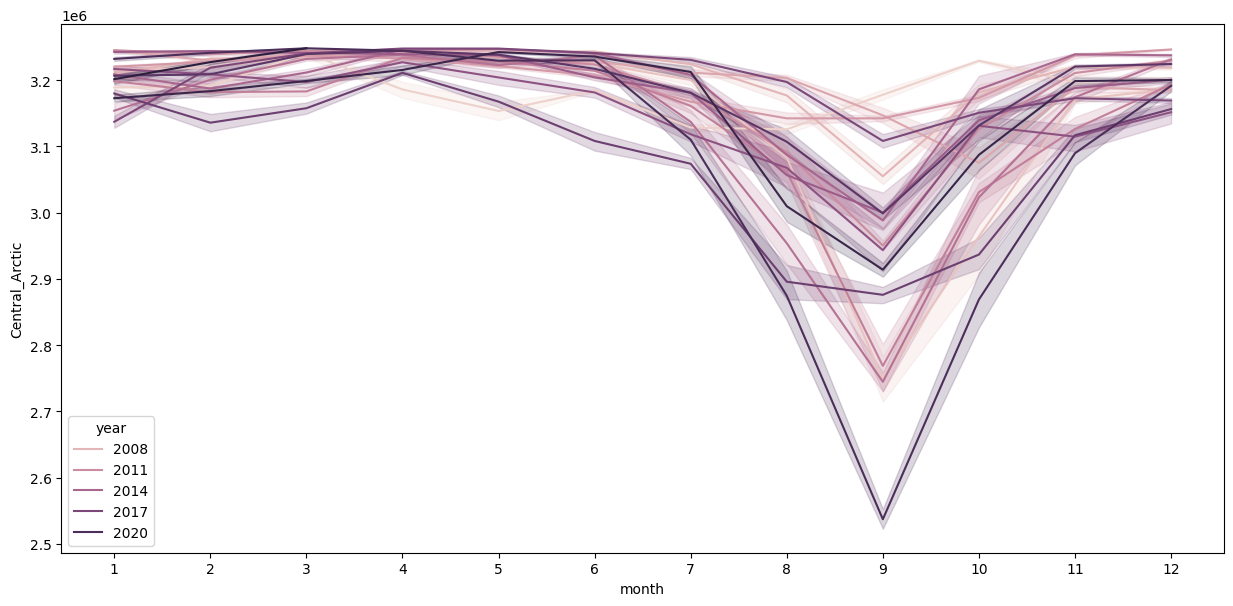

In [13]:
fig, axs = plt.subplots(figsize=(15, 7))
sns.lineplot(x='month', y='Central_Arctic', data=df_CA.reset_index(),  hue='year', ax=axs)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12]);


** There is a clear trend of ice melting during October every year can be seen from the graph. From January to may the extent of ice in the central Arctic is frozen for all the years and from may  it starts to melt and September is the month with lowest ice on the sea. 

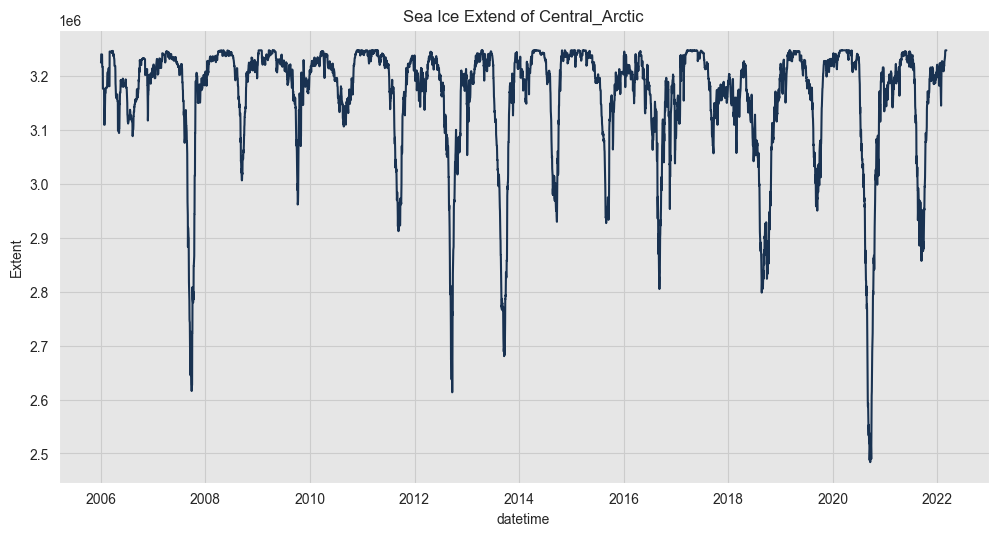

In [18]:

fig, ax = plt.subplots()
sns.lineplot(x='datetime', y='Central_Arctic', data=df_CA, ax=ax)
ax.set(title='Sea Ice Extend of Central_Arctic', ylabel='Extent');

In [19]:
df_m.columns

Index(['Northern_Hemisphere', 'Beaufort_Sea', 'Chukchi_Sea',
       'East_Siberian_Sea', 'Laptev_Sea', 'Kara_Sea', 'Barents_Sea',
       'Greenland_Sea', 'Baffin_Bay_Gulf_of_St._Lawrence',
       'Canadian_Archipelago', 'Hudson_Bay', 'Central_Arctic', 'Bering_Sea',
       'Baltic_Sea', 'Sea_of_Okhotsk', 'Yellow_Sea', 'Cook_Inlet', 'date',
       'day', 'month', 'year', 'datetime'],
      dtype='object')

### Creating a *polar plot* that depicts the seasonal change over the year in a circle

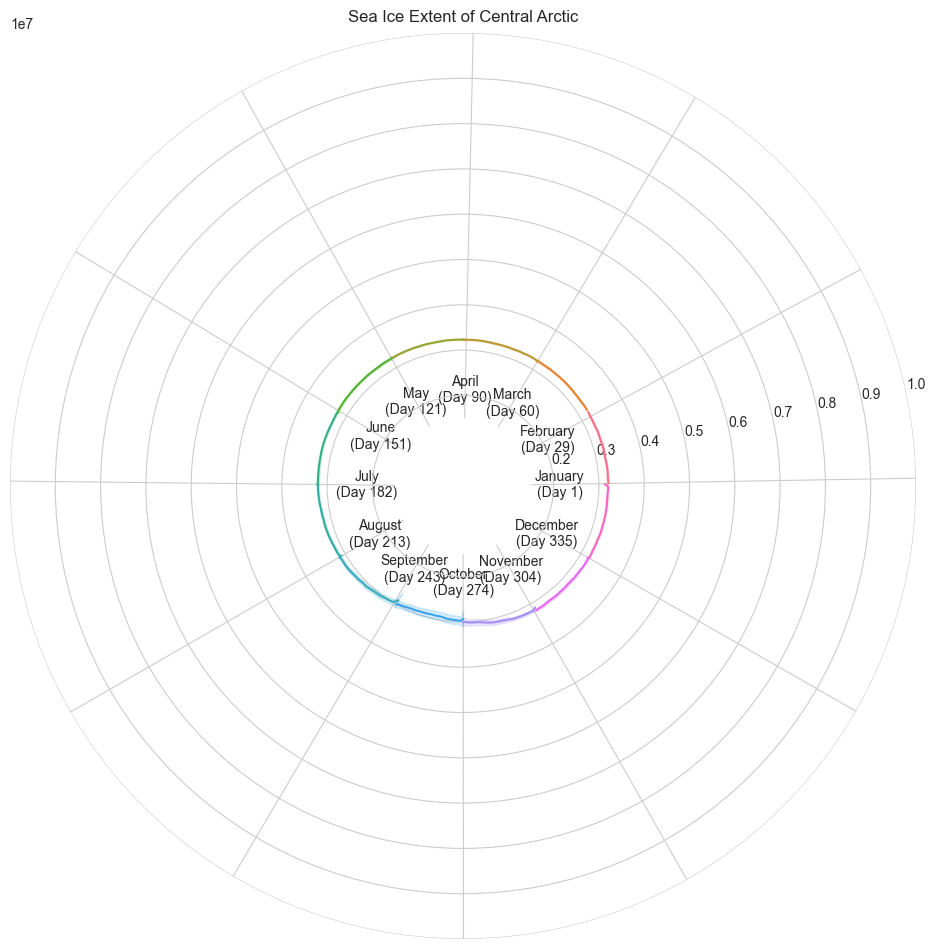

In [20]:
# Polar plot for seasonality 
ax = plt.subplot(111, projection='polar')

# Convert and plot data
df_CA \
    .assign(day_of_year_cyclic = lambda x: x['dayofyear'].transform(lambda x: 2*np.pi*x/365.25)) \
    .pipe((sns.lineplot, 'data'), 
        x='day_of_year_cyclic', 
        y='Central_Arctic', 
        hue='month',
        palette=sns.color_palette("husl", 12),
        ax=ax
    )

days_per_month=[monthrange(2021, i)[1] for i in range(1,13)]                    #findout how many days each month has  
month_theta=(np.array(days_per_month).cumsum()-days_per_month[0]+1)*2*np.pi/365.25 #find the starting day for each month and turn it into an angle 
month_label=[month_name[i] for i in range(1,13)]
month_label=[label+'\n(Day ' +str(int(month_theta[ind]*365.25/np.pi/2)) +')' for ind,label in enumerate(month_label)]

ax.set_facecolor('white')
ax.spines.clear()
ax.set_xticks(month_theta)
ax.set_xticklabels(month_label)
ax.set_ylim(10000000,1500000)
#ax.set_yticks(yt:=[10000000,300000,600000,900000,1200000])
#ax.set_yticklabels([str(t)+'sqkm' for t in yt], rotation = 45)
ax.set_rlabel_position(12) 
ax.xaxis.set_tick_params(which='major',pad=10)

ax.set_rorigin(-5)
ax.set_ylabel('')
ax.set_xlabel('')
ax.legend().set_visible(False)

ax.set_title('Sea Ice Extent of Central Arctic', va='bottom');
ax.figure.set_figwidth(12)
ax.figure.set_figheight(12)

#ax.figure.savefig("Basel_Temp_polar.png")

## Smoothing

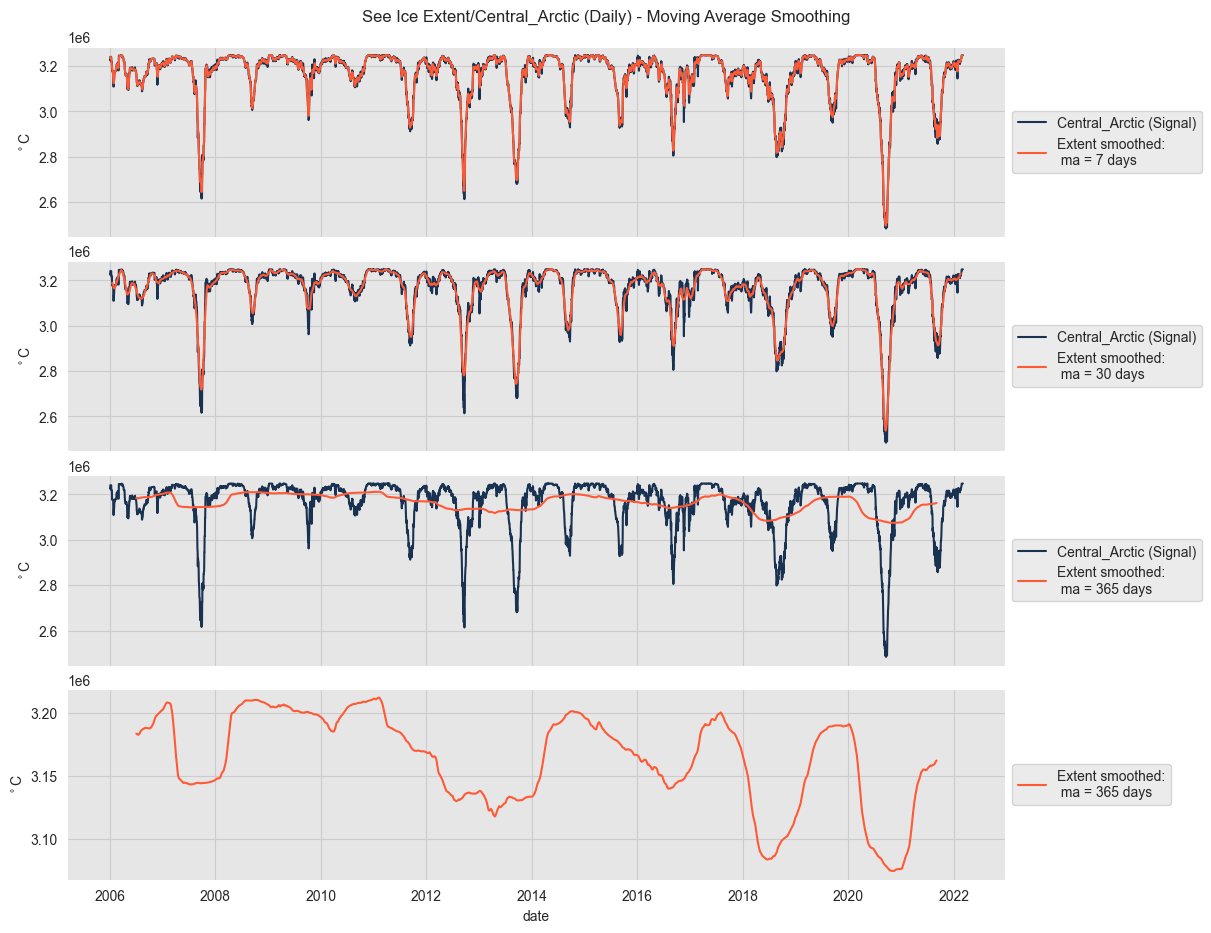

In [21]:
# Plot moving average of different length (week, month, year)
ma = [7, 30, 365]

smooth_df_CA = df_CA \
    .reset_index() \
    .assign(date = lambda x: x['date'].transform(pd.to_datetime)) # creating a new column called date and transforming to datetime object

# Smooth and plot
fig, ax = plt.subplots(4, 1, figsize=(12, 9), constrained_layout=True, sharex=True)

for i, m in enumerate(ma):

    smooth_df_CA [f'extent_smooth_ma_{m}'] = smooth_df_CA['Central_Arctic'].rolling(window=m,center=True).mean()

    sns.lineplot(x='date', y='Central_Arctic', label='Central_Arctic (Signal)', data=smooth_df_CA,  ax=ax[i])
    sns.lineplot(x='date', y=f'extent_smooth_ma_{m}', label=f'Extent smoothed:\n ma = {m} days', data=smooth_df_CA, color=NF_ORANGE, ax=ax[i])


    ax[i].legend(title='', loc='center left', bbox_to_anchor=(1, 0.5))
    ax[i].set(title='', ylabel=r'$^\circ$C');
    
sns.lineplot(x='date', y=f'extent_smooth_ma_{m}', label=f'Extent smoothed:\n ma = {m} days', data=smooth_df_CA, color=sns_c[1], ax=ax[i+1])
ax[i+1].legend(title='', loc='center left', bbox_to_anchor=(1, 0.5))
ax[i+1].set(title='', ylabel=r'$^\circ$C');
    
    
plt.suptitle('See Ice Extent/Central_Arctic (Daily) - Moving Average Smoothing', y=1.02);

## Time Series Decomposition

Doing time series decompose is to understand what the sources of variation are we see in the data.

 
This method is based on moving averages and returns the **trend**, **seasonality** and **residuals** of our timeseries.

The steps inside of this function is:
1. check for global trends using Moving average
2. de-trend our data by substituting the trend values from the original data
3. estimate seasonal component by taking averages of each season's value - 
        (for example, the effect of January is the average of all de-trended January values in the data)



In [22]:
df_CA

,datetime,Central_Arctic,Northern_Hemisphere,date,year,month,day,dayofyear
0,2006-01-01,3225371.74,13034723.95,2006-01-01,2006,1,1,1
1,2006-01-02,3225371.74,13034723.95,2006-01-02,2006,1,2,2
2,2006-01-03,3240507.71,13170663.24,2006-01-03,2006,1,3,3
3,2006-01-04,3240326.47,13409715.53,2006-01-04,2006,1,4,4
4,2006-01-05,3240326.47,13416779.12,2006-01-05,2006,1,5,5
...,...,...,...,...,...,...,...,...
5860,2022-03-01,3248012.93,15065044.15,2022-03-01,2022,3,1,60
5861,2022-03-02,3248012.93,14900614.73,2022-03-02,2022,3,2,61
5862,2022-03-03,3248012.93,14935641.30,2022-03-03,2022,3,3,62
5863,2022-03-04,3248012.93,15008089.95,2022-03-04,2022,3,4,63


## Extracting the yearly seasonality

In [14]:
df_Central_Arctic = df_CA[['datetime','Central_Arctic']]
df_Central_Arctic.to_csv('CArctic.csv', encoding='utf-8', index=False)

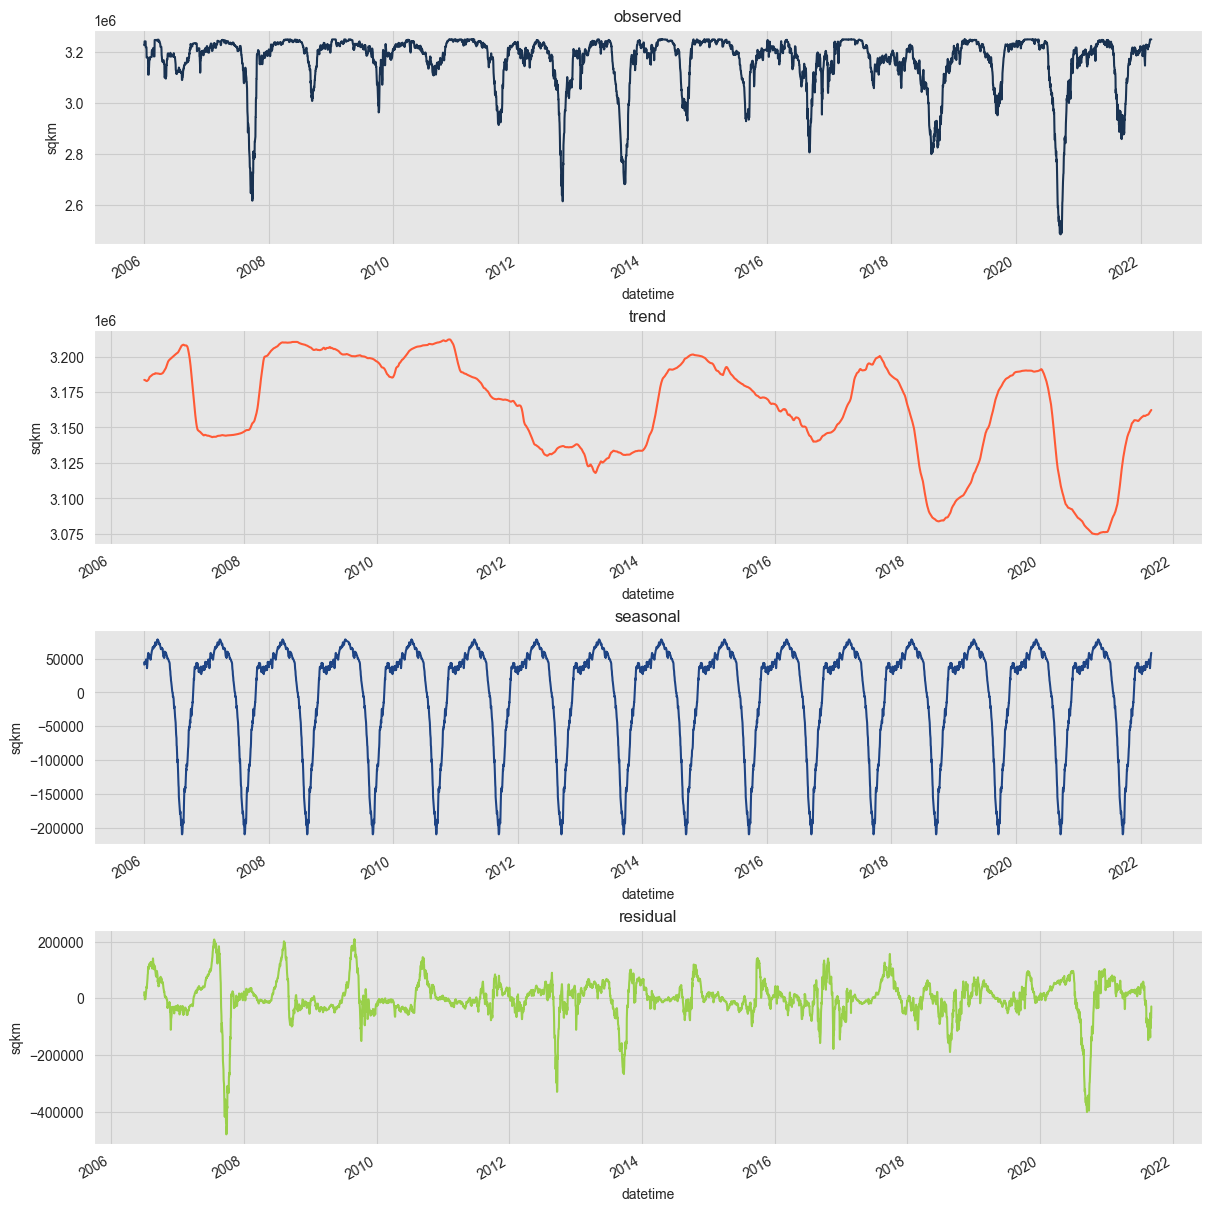

In [24]:
# We use the parameter `period` = 365 to extract the yearly seasonality.
from statsmodels.tsa.seasonal import seasonal_decompose
data=pd.read_csv('CArctic.csv',header=0,squeeze=True,index_col=[0],parse_dates=[0])
seas_decomp_yearly = seasonal_decompose(
    data,
    #y=raw_df['datetime'],
    model='additive',
    period=365
)
# Plot data
fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
seas_decomp_yearly.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='observed', ylabel=r'sqkm')
seas_decomp_yearly.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend', ylabel=r'sqkm')
seas_decomp_yearly.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal', ylabel=r'sqkm')
seas_decomp_yearly.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual', ylabel=r'sqkm');

## Checking for Stationarity

**A time series is said to be stationary if its statistical properties do not change over time.**

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -7.535255
p-value: 0.000000
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 0.513152
p-value: 0.038704
----------------------------------------


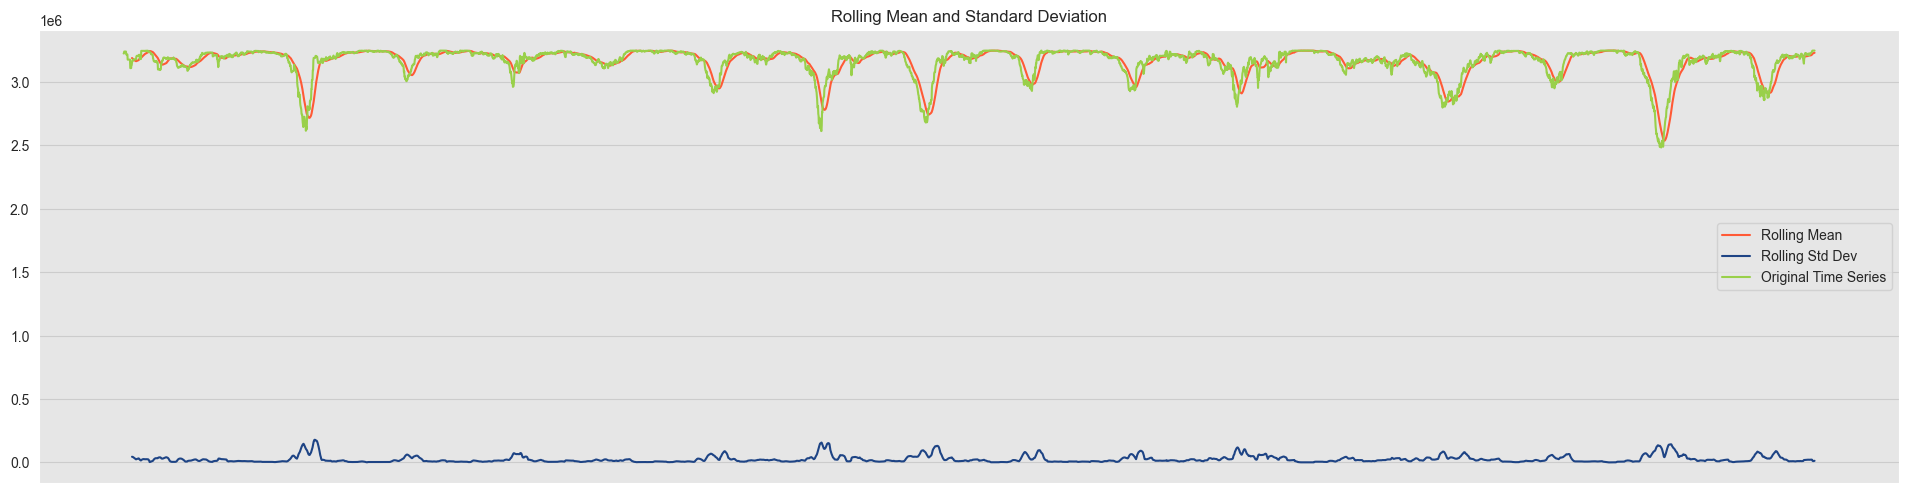

In [25]:
# Test for stationarity 

def stationarity_test(Central_Arctic_Extent):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = Central_Arctic_Extent.rolling(30).mean()
    rolling_std_dev = Central_Arctic_Extent.rolling(30).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(Central_Arctic_Extent, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(Central_Arctic_Extent,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(Central_Arctic_Extent, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df_CA['Central_Arctic'])

## De-trend the Time Series

In [26]:
# De-trending the time series
df_CA['Central_Arctic_Detrend'] = (df_m['Central_Arctic'] - df_m['Central_Arctic'].shift(30))

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -8.679693
p-value: 0.000000
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 0.009124
p-value: 0.100000
----------------------------------------


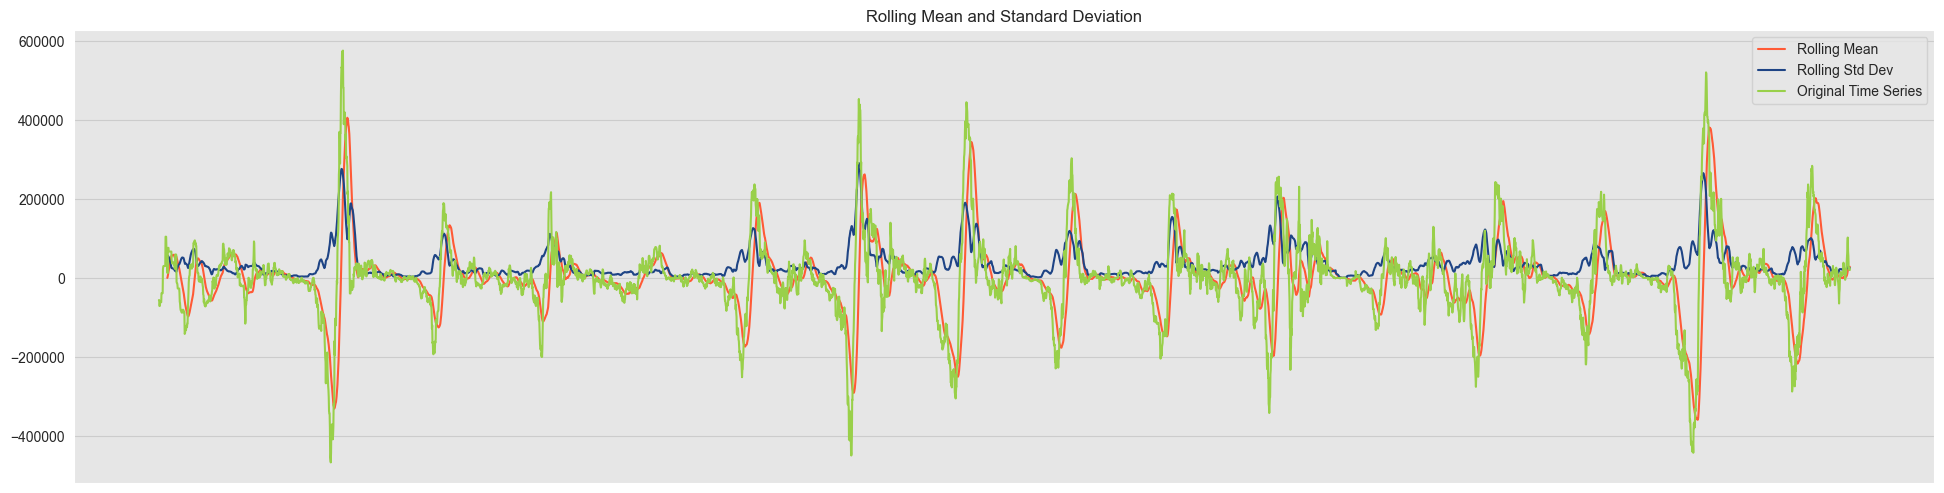

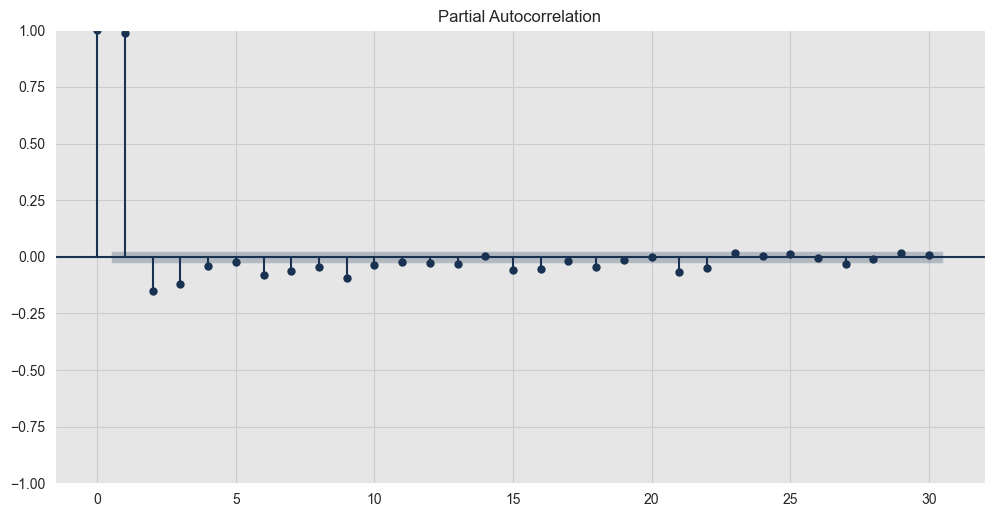

In [27]:
# Test for stationarity after de-trending 
def stationarity_test(Central_Arctic_Extent):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = Central_Arctic_Extent.rolling(30).mean()
    rolling_std_dev = Central_Arctic_Extent.rolling(30).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(Central_Arctic_Extent, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(Central_Arctic_Extent,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(Central_Arctic_Extent, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df_CA['Central_Arctic_Detrend'].dropna())

# Partial Autocorrelation Plot
pacf = plot_pacf(df_CA['Central_Arctic_Detrend'].dropna(), lags=30)

Above is an example of an autocorrelation plot. Looking closely, you realize that the first value and the 24th value have a high autocorrelation. Similarly, the 12th and 36th observations are highly correlated. This means that we will find a very similar value at every 24 unit of time.

## Splitting the Data

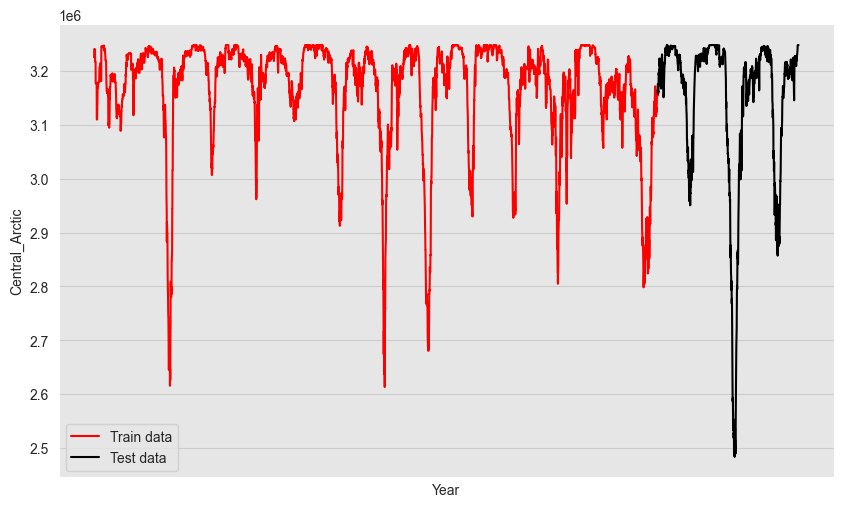

In [28]:
# Split data into train and test set
df_arima = df_CA['Central_Arctic']
train_test_split_ratio = int(len(df_arima)*0.8)
train_data, test_data = df_arima[:train_test_split_ratio], df_arima[train_test_split_ratio:]

# Plotting the train and test set
plt.figure(figsize=(10,6))
plt.xlabel('Year')
plt.ylabel('Central_Arctic')
plt.xticks([])
plt.plot(train_data, 'red', label='Train data')
plt.plot(test_data, 'black', label='Test data')
plt.legend();

### Simple Exponential Smoothing

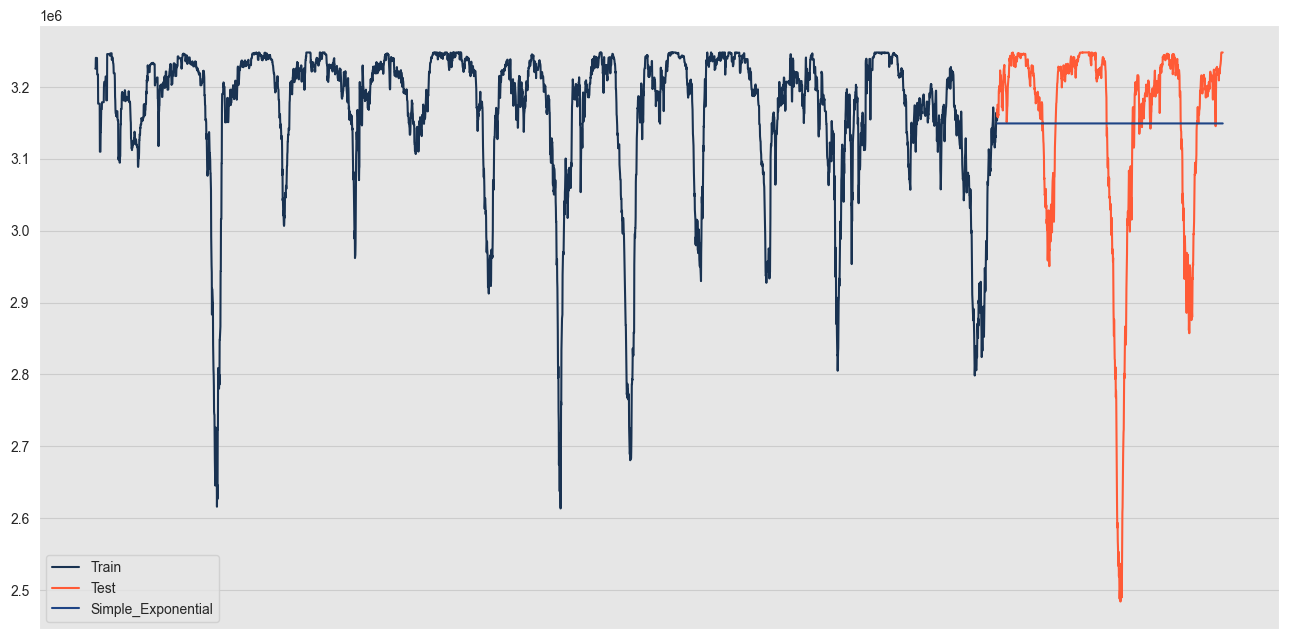

Simple Exponential Smoothing RMS :- 146909.64 & Smoothing Level :- 0.15


In [29]:
# Simple Exponential Smoothing Method
pred_values = test_data.copy()
pred_values = pd.DataFrame(pred_values)

simple_exponential_df = pd.DataFrame(columns = ['RMS','Smoothing Level'])

from itertools import permutations
perm = permutations(list(np.linspace(0.05,1,num=20)), 1)
for i in list(perm):
    fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = i[0])
    pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

    rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential)),3)
    simple_exponential_df = simple_exponential_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0]} , ignore_index=True)

opt_values = simple_exponential_df.loc[simple_exponential_df['RMS'] == min(simple_exponential_df['RMS']),['Smoothing Level']].values


# Use optimised values from the lists
fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0])
pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Simple_Exponential'], label='Simple_Exponential')
plt.xticks([])
plt.legend(loc='best')
plt.show()

rms_sim_exp = sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential))
print("Simple Exponential Smoothing RMS :- " + str(round(rms_sim_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)))

### Holt's Exponential Smoothing

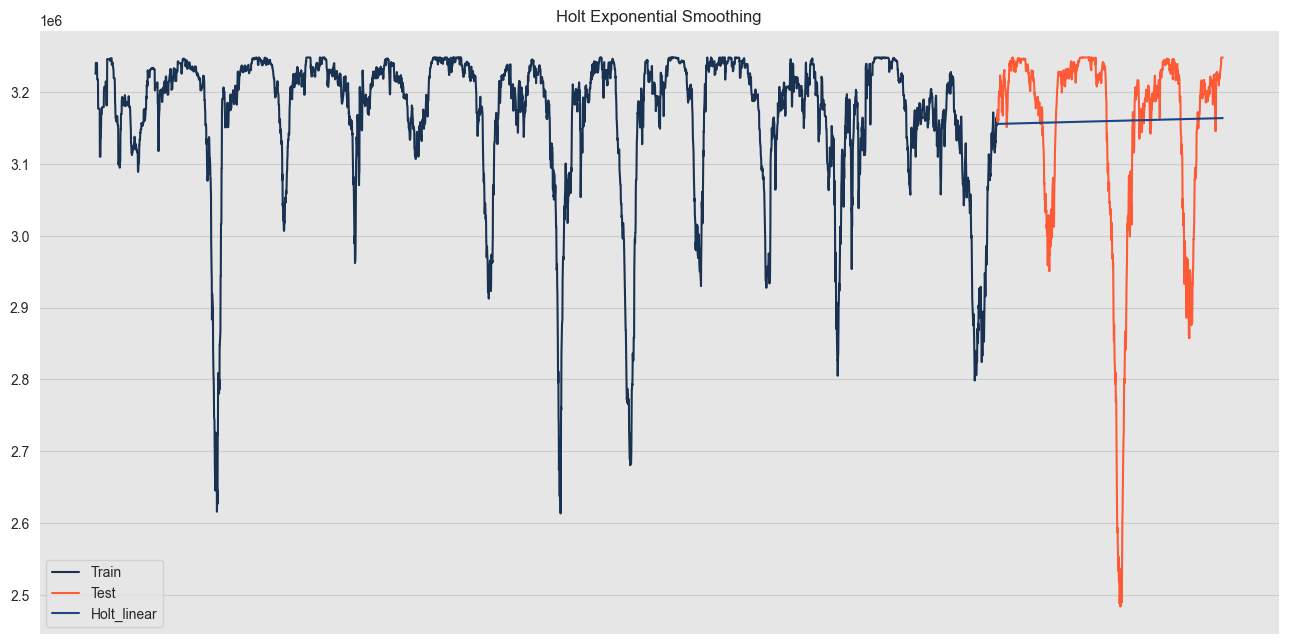

Holt’s Exponential Smoothing RMS :- 147684.835 & Smoothing Level :- 0.5 & Smoothing Slope :- 0.85


In [30]:
# Holt's Exponential Smoothing Method
holt_linear_df = pd.DataFrame(columns = ['RMS','Smoothing Level','Smoothing Slope'])

perm = permutations(list(np.linspace(0.05,1,num=20)), 2)
for i in list(perm):
    fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
    pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

    rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear)),3)
    holt_linear_df = holt_linear_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0], 'Smoothing Slope':i[1]} , ignore_index=True)

opt_values = holt_linear_df.loc[holt_linear_df['RMS'] == min(holt_linear_df['RMS']),['Smoothing Level','Smoothing Slope']].values


# Using optimised values from the lists.
fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0],smoothing_slope=opt_values[0][1])
pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Holt_linear'], label='Holt_linear')
plt.xticks([])
plt.legend(loc='best')
plt.title('Holt Exponential Smoothing')
plt.show()

rms_holt_exp = sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear))
print("Holt’s Exponential Smoothing RMS :- " + str(round(rms_holt_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)) + " & Smoothing Slope :- "+str(round(opt_values[0][1],3)))

### Auto-Regressive Integrated Moving Average (ARIMA)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=101047.256, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=153787.054, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=100988.531, Time=0.37 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=100998.085, Time=0.40 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=100985.710, Time=0.49 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=100999.191, Time=0.32 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=100992.016, Time=0.84 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=100975.008, Time=0.55 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=100998.407, Time=0.29 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=100975.702, Time=0.84 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=100973.373, Time=0.62 sec
 ARIMA(1,0,4)(0,0,0)[0]   

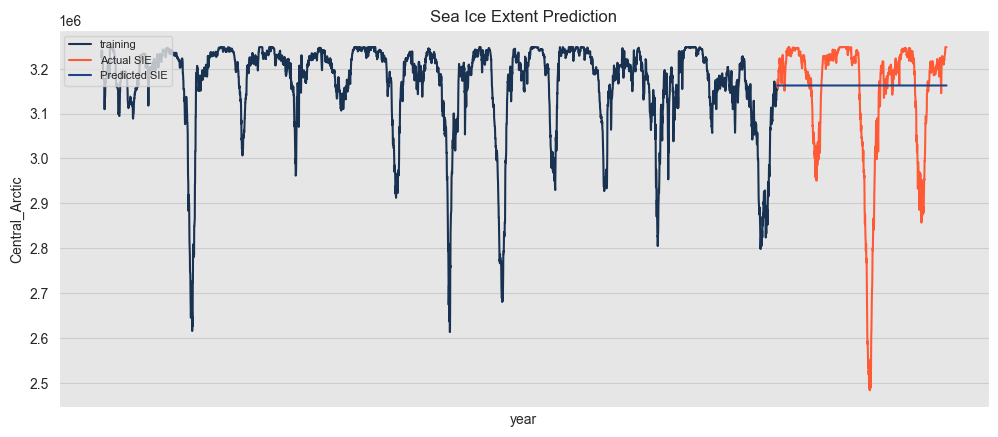

Auto-Arima RMSE :- 147609.909


In [31]:
# Auto ARIMA Method
arima_model = auto_arima(train_data,
                      start_p=1, start_q=1,
                      max_p=5, max_q=5,
                      test='adf',        
                      trace=True,
                      alpha=0.05,
                      scoring='mse',
                      suppress_warnings=True,
                      seasonal = False
                      )

# Fit the final model with the order
fitted_model = arima_model.fit(train_data) 
print(fitted_model.summary())

# Forecasting values
forecast_values = fitted_model.predict(len(test_data), alpha=0.05) 
fcv_series = pd.Series(forecast_values[0], index=test_data.index)

# Plot the predicted stock price and original price
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='Actual SIE')
plt.plot(fcv_series,label='Predicted SIE')
plt.title('Sea Ice Extent Prediction')
plt.xlabel('year')
plt.ylabel('Central_Arctic')
plt.xticks([])
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Evaluate the model by calculating RMSE
rms_auto_arima = sqrt(mean_squared_error(test_data.values, fcv_series))
print("Auto-Arima RMSE :- " + str(round(rms_auto_arima,3)))

## Evaluation of the Models

To evaluate the performance of the model, we will use Root Mean Squared Error (RMSE) and compare which model performed the best.

In [32]:
# Printing RMSE of all the methods
print("RMSE of all the methods")
print("Auto-Arima: ", round(rms_auto_arima,3))
print("Simple Exponential Smoothing: ", round(rms_sim_exp,3))
print("Holt’s Exponential Smoothing: ", round(rms_holt_exp,3))

RMSE of all the methods
Auto-Arima:  147609.909
Simple Exponential Smoothing:  146909.64
Holt’s Exponential Smoothing:  147684.835


In [33]:
# pyplot.plot(test)
# pyplot.plot(predictions, color='red')
# pyplot.show()

# Converted the dataframe to CSV

In [34]:

df_CA.to_csv('Central_Arctic.csv', encoding='utf-8', index=False)

In [35]:
data = pd.read_csv('Central_Arctic.csv')
#data

# MLFlow

In [44]:
import mlflow

from modeling.config import EXPERIMENT_NAME
TRACKING_URI = open(".mlflow_uri").read().strip()


In [45]:
# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)
#mlflow.start_run()
#run = mlflow.active_run()

<Experiment: artifact_location='s3://neuefische-mlflow/mlflow-artifacts/42', experiment_id='42', lifecycle_stage='active', name='Ice_cream', tags={}>

In [46]:
# Split data into train and test set
df_arima = df_CA['Central_Arctic']
train_test_split_ratio = int(len(df_arima)*0.8)
train_data, test_data = df_arima[:train_test_split_ratio], df_arima[train_test_split_ratio:]


#alpha = float(sys.argv[1]) if len(sys.argv) > 1 else 0.5
# Provide uri and connect to your tracking server
# mlflow.set_tracking_uri('http://127.0.0.1:5000/')

In [47]:
#mlflow.end_run()

In [49]:
#seting parameters that should be logged on MLFlow
#these parameters were used in feature engineering (inputing missing values)
#or parameters of the model (fit_intercept for Linear Regression model)
params = {
      "trace": True,
      "alpha": 0.05,
      "scoring": "mse",
      "seasonal": False,
      "model": "ARIMA"
  }

In [50]:


# Auto ARIMA Method
with mlflow.start_run():

    arima_model = auto_arima(train_data,
                        start_p=1, start_q=1,
                        max_p=5, max_q=5,
                        test='adf',        
                        trace=True,
                        alpha=0.05,
                        scoring='mse',
                        suppress_warnings=True,
                        seasonal = False
                        )

    # Fit the final model with the order
    fitted_model = arima_model.fit(train_data) 
    print(fitted_model.summary())

    # Forecasting values
    forecast_values = fitted_model.predict(len(test_data), alpha=0.05) 
    fcv_series = pd.Series(forecast_values[0], index=test_data.index)


    # Evaluate the model by calculating RMSE
    rms_auto_arima = sqrt(mean_squared_error(test_data.values, fcv_series))
    print("RMSE :- " + str(round(rms_auto_arima,3)))

    #logging params to mlflow
    mlflow.log_params(params)

    mlflow.log_metric("rmse", rms_auto_arima)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=101047.256, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=153787.054, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=100988.531, Time=0.33 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=100998.085, Time=0.43 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=100985.710, Time=0.56 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=100999.191, Time=0.28 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=100992.016, Time=0.84 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=100975.008, Time=0.58 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=100998.407, Time=0.31 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=100975.702, Time=0.80 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=100973.373, Time=0.72 sec
 ARIMA(1,0,4)(0,0,0)[0]   

In [ ]:
#!mlflow ui